![](https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/se_03.png)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CLDiego/uom_fse_dl_workshop/blob/main/SE03_CA_Training_neural_networks.ipynb)
# Workshop Instructions
***
- <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="20"/> Follow along by typing the code yourself - this helps with learning!
- <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> Code cells marked as "Exercise" are for you to complete
- <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> Look for hints if you get stuck
- <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/success.svg" width="20" /> Compare your solution with the provided answers
- <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/list.svg" width="20" /> Don't worry if you make mistakes - debugging is part of learning!

In [1]:
# Download utils from GitHub
!wget -q --show-progress https://raw.githubusercontent.com/CLDiego/uom_fse_dl_workshop/main/colab_utils.txt -O colab_utils.txt
!wget -q --show-progress -x -nH --cut-dirs=3 -i colab_utils.txt

colab_utils.txt     100%[===================>]   1.57K  --.-KB/s    in 0s      
utils/__init__.py   100%[===================>]   1.75K  --.-KB/s    in 0s      
utils/__version__.p 100%[===================>]     234  --.-KB/s    in 0s      
utils/core.py       100%[===================>]  55.36K  --.-KB/s    in 0.01s   
utils/quizzes.json  100%[===================>]  18.63K  --.-KB/s    in 0s      
utils/solutions.jso 100%[===================>]  45.93K  --.-KB/s    in 0.003s  
utils/data/__init__ 100%[===================>]     766  --.-KB/s    in 0s      
utils/data/datasets 100%[===================>]   8.36K  --.-KB/s    in 0s      
utils/data/download 100%[===================>]  11.24K  --.-KB/s    in 0s      
utils/data/uwmgi.py 100%[===================>]  11.78K  --.-KB/s    in 0s      
utils/ml/__init__.p 100%[===================>]     526  --.-KB/s    in 0s      
utils/ml/metrics.py 100%[===================>]   3.60K  --.-KB/s    in 0s      
utils/ml/scaling.py 100%[===============

In [2]:
from pathlib import Path
import sys

repo_path = Path.cwd()
if str(repo_path) not in sys.path:
    sys.path.append(str(repo_path))

import utils
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import torch

print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
else:
    print("No GPU available. Please ensure you've enabled GPU in Runtime > Change runtime type")

checker = utils.core.ExerciseChecker("SE03")
quizzer = utils.core.QuizManager("SE03")

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 1.1.0+4edc6ee
GPU available: False
No GPU available. Please ensure you've enabled GPU in Runtime > Change runtime type


# 1. PyTorch workflow
***
The previous session we had a look at the basics of neural networks and how to train a single layer perceptron. In this session we will look at the PyTorch framework and how to use it to build and train neural networks.

Most deep learning projects follow a similar workflow. The following figure illustrates the typical workflow of a PyTorch project:

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/pytorch_workflow.png" width="80%">
</div>

The workflow consists of the following steps:

| Step | Description |
|------|----------|
| Obtain Data | Collect and preprocess the data for training and testing |
| Prepare Data | Setup data in PyTorch format |
| Pre-process Data | Normalize and augment the data. This may involve data cleaning, normalization, and splitting the data into training, validation, and test sets. |
| Activation Function | Choose an activation function for the model. This may involve selecting a suitable activation function for the model, such as ReLU, sigmoid, or tanh. |
| Model | Define the model architecture. |
| Choose optimiser | Select an optimiser for the model. |
| Choose loss function | Select a loss function for the model. |
| Create training loop | Define the training steps, including forward pass, backward pass, and parameter updates. |
| Fit model | Train the model using the training data. |
| Evaluate model | Evaluate the model using the validation and test data to make predictions |
| Improve model | Fine-tune the model by adjusting hyperparameters, adding regularization, or modifying the architecture. |
| Save or deploy model | Save the trained model for future use or deploy it in a production environment. |

## Step 1: Obtain Data
***
In this notebook we are going to be using the [ARKOMA dataset](https://www.sciencedirect.com/science/article/pii/S2352340923007989). The dataset is intended to be used as a benchmark for the creation of Neural Networks to perform inverse kinematics for robotic arms using a NAO robot. The dataset contains data for two different robotic arms: the left arm and the right arm. The data is generated using a physics engine that simulates the movement of the robotic arms in a 3D environment. The dataset contain 10,000 input-output data pairs for both arms. The input data is the end-effector position of the robotic arm, and the output data is the joint angles of the robotic arm.

The input parameters are:

| Notation | Description |
|------|----------|
| $ P_{x} $ | The end-effector position with respect to the torso's x-axis |
| $ P_{y} $ | The end-effector position with respect to the torso's y-axis |
| $ P_{z} $ | The end-effector position with respect to the torso's z-axis |
| $ R_{x} $ | The end-effector orientation relative to the torso's x-axis |
| $ R_{y} $ | The end-effector orientation relative to the torso's y-axis |
| $ R_{z} $ | The end-effector orientation relative to the torso's z-axis |

The output parameters are:

| Notation | Left Arm Joint | Left Arm Range(rad) | Right Arm Joint | Right Arm Range(rad) |
|----------|----------------|--------------------|-----------------|--------------------|
| $ \theta_{1} $ | LShoulder Pitch | [-2.0857, 2.0857] | RShoulder Pitch | [-2.0857, 2.0857] |
| $ \theta_{2} $ | LShoulder Roll | [-0.3142, 1.3265] | RShoulder Roll | [-1.3265, 0.3142] |
| $ \theta_{3} $ | LElbow Yaw | [-2.0857, 2.0857] | RElbow Yaw | [-2.0857, 2.0857] |
| $ \theta_{4} $ | LElbow Roll | [-1.5446, 0.0349] | RElbow Roll | [-0.0349, 1.5446] |
| $ \theta_{5} $ | LWrist Yaw | [-1.8238, 1.8238] | RWrist Yaw | [-1.8238, 1.8238]  |

In this notebook, we are going to focus on the right arm. The data is stored in CSV format. To load the data, we will use the `pandas` library.

In [3]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('ARKOMA',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=True)


Downloading:
ARKOMA: The Dataset to Build Neural Networks-Based Inverse Kinematics for NAO Robot Arms
> Authors: Arif Nugroho, Eko Mulyanto Yuniarno, Mauridhi Hery Purnomo
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340923007989



Extracting brg4dz8nbb-1.zip: 100%|██████████| 1/1 [00:00<00:00, 272.41it/s]


Removed compressed file: /content/datasets/brg4dz8nbb-1.zip
Found nested archive: Dataset on NAO Robot Arms.zip


Extracting Dataset on NAO Robot Arms.zip: 100%|██████████| 15/15 [00:00<00:00, 775.11it/s]

Removed compressed file: /content/datasets/brg4dz8nbb-1/Dataset on NAO Robot Arms.zip


In [5]:
# Set the path to the datasets (already provided above)
right_arm_path = dataset_path / 'Right Arm Dataset'

# Create file paths using a dictionary comprehension and format strings
file_parts = ['Train', 'Val', 'Test']
dataset_files = {
    part: {
        'features': right_arm_path / f'R{part}_x.csv',
        'targets': right_arm_path / f'R{part}_y.csv'
    } for part in file_parts
}

# Unpack into individual variables for compatibility with existing code
feats_train = dataset_files['Train']['features']
targets_train = dataset_files['Train']['targets']
feats_val = dataset_files['Val']['features']
targets_val = dataset_files['Val']['targets']
feats_test = dataset_files['Test']['features']
targets_test = dataset_files['Test']['targets']


## Step 2 and 3: Prepare and Pre-process Data
***
The next step is to pre-process the data. This involves normalizing the data and splitting it into training, validation, and test sets.

### Training, Validation, and Test Sets
***
One of the crucial steps in machine learning is to split the data into training, validation, and test sets. Each of these sets serves a specific purpose in the model development process:

| Dataset | Purpose | Typical Split | Usage | Analogy |
|---------|---------|---------------|--------|----------|
| Training Set | Used to train the model by adjusting weights and biases through backpropagation | 60-80% | Every training iteration | Like studying materials to learn a subject |
| Validation Set | Used to tune hyperparameters and monitor model performance during training to prevent overfitting | 10-20% | During model development | Like practice exams to gauge learning progress |
| Test Set | Used only once for final model evaluation; never used for training or tuning | 10-20% | Once, after training | Like a final exam with new, unseen questions |

The ARKOMA dataset has already been split into these three sets for us, which simplifies our workflow.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/>  **Note**: The test set is our generalisation benchmark. It is important to keep the test set separate from the training and validation sets to ensure that the model's performance is evaluated on unseen data. This helps us understand how well the model will perform in real-world scenarios.

In [6]:
# Load the datasets
# Training set
X_train = pd.read_csv(feats_train)
y_train = pd.read_csv(targets_train)
# Test set
X_test = pd.read_csv(feats_test)
y_test = pd.read_csv(targets_test)
# Validation set
X_val = pd.read_csv(feats_val)
y_val = pd.read_csv(targets_val)

print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")


X_train shape: (6000, 6) | y_train shape: (6000, 5)
X_test shape: (2000, 6) | y_test shape: (2000, 5)
X_val shape: (2000, 6) | y_val shape: (2000, 5)


In [7]:
X_train.head()

,Px,Py,Pz,Rx,Ry,Rz
0,116.12,-180.97,198.59,-10.39,-41.23,5.04
1,83.41,-228.19,-25.54,24.58,52.19,-43.12
2,45.81,-187.38,285.07,2.08,-81.96,-9.99
3,112.87,-146.16,-74.21,-19.96,56.73,13.66
4,175.85,-162.01,41.35,-21.91,5.63,10.07


In [8]:
y_train.head()

,joint1,joint2,joint3,joint4,joint5
0,-0.98727,-1.03049,-0.29515,1.19638,0.01696
1,0.49338,-0.92155,-1.00017,0.70232,1.33316
2,-1.32138,-0.60855,0.25970,0.48005,-0.29894
3,0.85806,-0.32185,-0.41366,0.38794,-0.00819
4,0.46961,-0.66923,0.44363,0.88413,-0.74223


### Normalisation
***
Normalisation is a crucial step in the pre-processing of data for machine learning models. It involves scaling the input features to a similar range, which helps improve the convergence speed and performance of the model. In this notebook, we will use Min-Max normalization to scale the input features to a range of [0, 1]. The formula for Min-Max normalization is as follows:
$$ X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

Where:
- $ X_{norm} $ is the normalized value.
- $ X$ is the original value.
- $ X_{min} $ is the minimum value of the feature.
- $ X_{max} $ is the maximum value of the feature.

The normalisation parameters will be computed from the training set and then applied to the validation and test sets. This helps to prevent data leakage and ensures that the model is evaluated on unseen data.

| Benefit | Description | Impact on Training |
|---------|-------------|-------------------|
| **Faster Convergence** | Normalized inputs lead to better-conditioned optimization | Reduces training time |
| **Numerical Stability** | Prevents extremely large or small values | Reduces risk of gradient explosions/vanishing |
| **Feature Scaling** | Makes all features contribute equally to the model | Prevents certain features from dominating |
| **Better Generalization** | Helps models transfer between different images | Improves performance on unseen data |

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 1**: Normalisation using Min-Max scaling

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training
X_train_scaled = scaler.transform(X_train)

# Inverse transform the scaled data to get the original values
X_train_original = scaler.inverse_transform(X_train_scaled)
```

In [10]:
# Exercise 1: Data Loading and Preprocessing 🎯

# Create PyTorch tensors from the training, validation, and test data
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create MinMaxScalers for feature and target normalization
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Fit the scalers on training data
x_scaler = x_scaler.fit(X_train_tensor)
y_scaler = y_scaler.fit(y_train_tensor)


# Transform all datasets and put them into tensors
X_train_scaled = torch.tensor(x_scaler.transform(X_train_tensor), dtype=torch.float32)
X_val_scaled = torch.tensor(x_scaler.transform(X_val_tensor), dtype=torch.float32)
X_test_scaled = torch.tensor(x_scaler.transform(X_test_tensor), dtype=torch.float32)


y_train_scaled = torch.tensor(y_scaler.transform(y_train_tensor), dtype=torch.float32)
y_val_scaled = torch.tensor(y_scaler.transform(y_val_tensor), dtype=torch.float32)
y_test_scaled = torch.tensor(y_scaler.transform(y_test_tensor), dtype=torch.float32)

# Check the normalized data range
print(f"X_train normalized range: [{X_train_scaled.min().item():.4f}, {X_train_scaled.max().item():.4f}]")
print(f"y_train normalized range: [{y_train_scaled.min().item():.4f}, {y_train_scaled.max().item():.4f}]")

# ✅ Check your answer
answer = {
    'X_train_tensor': X_train_tensor,
    'y_train_tensor': y_train_tensor,
    'X_train_scaled': X_train_scaled,
    'y_train_scaled': y_train_scaled,
    'scale_range_min': X_train_scaled.min().item(),
    'scale_range_max': X_train_scaled.max().item(),
}
checker.check_exercise(1, answer)


X_train normalized range: [0.0000, 1.0000]
y_train normalized range: [0.0000, 1.0000]
--------------------------------------------------------------------------------
✅ X_train_tensor is correct!
✅ y_train_tensor is correct!
✅ X_train_scaled is correct!
✅ y_train_scaled is correct!
✅ scale_range_min is correct!
✅ scale_range_max is correct!

🎉 Excellent! All parts are correct!


## Step 4: Activation Function
***
The next step is to choose an activation function for the model. The activation function introduces non-linearity to the model, allowing it to learn complex relationships in the data. The following table lists some common activation functions used in neural networks, along with their characteristics and best use cases:

| Function | Formula | Range | PyTorch Implementation | Best Used For |
|----------|---------|-------|-------------------|---------------|
| ReLU | $\displaystyle f(x) = \max(0, x)$ | $\displaystyle [0, \infty)$ | `torch.nn.ReLU()` | Hidden layers in most networks |
| Sigmoid | $\displaystyle f(x) = \frac{1}{1+e^{-x}}$ | $\displaystyle (0, 1)$ | `torch.nn.Sigmoid()` | Binary classification, gates in LSTMs |
| Tanh | $\displaystyle f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $\displaystyle (-1, 1)$ | `torch.nn.Tanh()` | Hidden layers when output normalization is needed |
| Leaky ReLU | $\displaystyle f(x) = \max(\alpha x, x)$ | $\displaystyle (-\infty, \infty)$ | `torch.nn.LeakyReLU(negative_slope=0.01)` | Preventing "dead neurons" problem |
| Softmax | $\displaystyle f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$ | $\displaystyle (0, 1)$ | `torch.nn.Softmax(dim=1)` | Multi-class classification output layer |

The choice of activation function depends on the specific problem and the architecture of the neural network.

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Tips**:
> - ReLU is the most commonly used activation function in hidden layers of deep networks due to its simplicity and effectiveness.
> - The activation function for the output layer depends on the type of problem being solved (e.g., regression, binary classification, multi-class classification).
***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/list.svg" width="20"/> **Common Mistakes to Avoid**:
> - Mixing activation functions in the same layer (e.g., using ReLU and sigmoid together) can lead to unexpected behavior.
> - Using activation functions that saturate (like sigmoid) in hidden layers can lead to vanishing gradients, making training difficult.
> - Forgetting to apply the activation function to the output layer can lead to incorrect predictions (e.g., not using softmax for multi-class classification).
> - Not considering the range of the output when choosing the activation function (e.g., using sigmoid for regression tasks).

In [11]:
print("\n🧠 Quiz 1: Choosing the right activation function")
quizzer.run_quiz(1)

print("\n🧠 Quiz 2: Combining activation functions")
quizzer.run_quiz(2)


🧠 Quiz 1: Choosing the right activation function
--------------------------------------------------------------------------------
📋 Activation Functions Quiz
--------------------------------------------------------------------------------
For a regression problem like predicting the robot arm joint angles, which activation function would be most appropriate for the output layer?

A. Sigmoid - to constrain all outputs between 0 and 1

B. ReLU - to ensure no negative values in the output

C. Linear (no activation) - to allow any numeric output value

D. Softmax - to convert outputs into probability distributions

E. Tanh - to constrain all outputs between -1 and 1

Enter your answer (A, B, C, etc.): C

✅ Correct!

📚 Explanation:
For regression problems, where we need to predict continuous values like joint
angles, the linear activation (or no activation) is most appropriate for the
output layer. This is because:  1. Regression outputs need the full range of
possible values, not constrai


## Step 5: Model
***
The next step is to define the model architecture. In order to create a Neural Network we need to stack multiple neurons together. This is known as a **layer**. A layer is a collection of neurons that work together to process the input data. A simple ANN is formed by three types of layers:
   - **Input Layer**: Receives the input data.
   - **Hidden Layers**: Intermediate layers that process the data.
   - **Output Layer**: Produces the final output.

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/layers.png" width="35%">
</div>


The following table summarises the different types of layers available in PyTorch:

| Layer Type | Class | Description | Common Uses |
|------------|-------|-------------|------------|
| Fully Connected | `torch.nn.Linear(in_features, out_features)` | Standard dense layer | Classification, regression |
| Convolutional | `torch.nn.Conv2d(in_channels, out_channels, kernel_size)` | Spatial feature extraction | Image processing |
| Recurrent | `torch.nn.RNN(input_size, hidden_size)` | Sequential data processing | Time series, text |
| LSTM | `torch.nn.LSTM(input_size, hidden_size)` | Long-term dependencies | Complex sequences |
| Embedding | `torch.nn.Embedding(num_embeddings, embedding_dim)` | Word vector representations | NLP tasks |
| BatchNorm | `torch.nn.BatchNorm2d(num_features)` | Normalizes layer inputs | Training stability |
| Dropout | `torch.nn.Dropout(p=0.5)` | Randomly zeros elements | Regularization |

The choice of layer type depends on the specific problem and the architecture of the neural network. For example, convolutional layers are commonly used in image processing tasks, while recurrent layers are used for sequential data processing.

### Number of Layers and Neurons
***
The number of layers and neurons in each layer is a hyperparameter that needs to be tuned. The following table summarises the common practices for choosing the number of layers and neurons:

| Layer Type | Common Practices |
|----------------|------------------|
| Input Layer | Number of neurons = number of input features |
| Hidden Layers | 1-3 hidden layers are common for most tasks. More complex tasks may require more layers. |
| Output Layer | Number of neurons = number of output features (e.g., 1 for regression, number of classes for classification) |
| Number of Neurons | Common practices: 2^n, where n is the number of layers. A common practice is to start with a number of neurons equal to the number of input features and then reduce the number of neurons in each subsequent layer. |

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20" /> **Tips**:
> - Start with a simple architecture and gradually increase complexity as needed.
> - The number of neurons in each layer can be adjusted based on the complexity of the problem.
> - Use activation functions after each layer to introduce non-linearity.
> - Experiment with different layer types and configurations to find the best architecture for your problem.




In [12]:
# Quiz 3: Network Width
print("\n🧠 Quiz 3: Understanding Network Width for Inverse Kinematics")
quizzer.run_quiz(3)

# Quiz 4: Network Depth
print("\n🧠 Quiz 4: Understanding Network Depth for Inverse Kinematics")
quizzer.run_quiz(4)

# Quiz 5: Regularization Techniques
print("\n🧠 Quiz 5: Regularization Techniques for Kinematics Models")
quizzer.run_quiz(5)


🧠 Quiz 3: Understanding Network Width for Inverse Kinematics
--------------------------------------------------------------------------------
📋 Neural Network Width Quiz
--------------------------------------------------------------------------------
For the robot arm inverse kinematics regression problem, which statement about network width (number of neurons in hidden layers) is most accurate?

A. A single neuron in each hidden layer is sufficient since this is a simple regression task

B. The number of neurons should exactly match the number of input features (6)

C. The hidden layers should have more neurons than inputs to capture complex spatial relationships

D. The hidden layers should have fewer neurons than the output to prevent overfitting

E. The width of the network doesn't impact performance, only the depth matters

Enter your answer (A, B, C, etc.): C

✅ Correct!

📚 Explanation:
The hidden layers should have more neurons than inputs to capture complex
spatial relationshi

### Initialising Weights and Biases
***

In the previous session we looked at the concept of weights and biases. With our Perceptron we initialised the weights and biases to random values. In PyTorch, we can use different methods to initialise the weights and biases of a neural network.

The importance of initialising weights and biases lies in the fact that they can significantly affect the convergence speed and performance of the neural network. Proper initialisation can help prevent issues such as vanishing or exploding gradients, which can hinder the training process.

| Initialisation Method | Formula | PyTorch Code | Description |
|-----------------------|----------|--------------|-------------|
| Xavier/Glorot Initialisation | $\displaystyle W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}})$ | `torch.nn.init.xavier_uniform_(tensor)` | Suitable for sigmoid and tanh activations. |
| He Initialisation | $\displaystyle W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Kaiming Normal Initialisation | $\displaystyle W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ | `torch.nn.init.kaiming_normal_(tensor)` | Suitable for ReLU activations. |
| Kaiming Uniform Initialisation | $\displaystyle W \sim \mathcal{U}(-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}})$ | `torch.nn.init.kaiming_uniform_(tensor)` | Suitable for ReLU activations. |
| Zero Initialisation | $\displaystyle W = 0$ | `torch.nn.init.zeros_(tensor)` | All weights are set to zero. Not recommended. |
| Random Initialisation | $\displaystyle W \sim \mathcal{U}(-1, 1)$ | `torch.nn.init.uniform_(tensor)` | Weights are randomly initialised between -1 and 1. |

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Tips**:
> - Use Xavier or He initialisation for most cases, as they are designed to maintain the variance of activations across layers.
> - Avoid zero initialisation, as it can lead to symmetry problems where all neurons learn the same features.
> - PyTorch uses Kaiming initialisation by default for `torch.nn.Linear` layers, which is suitable for ReLU activations.
> - Experiment with different initialisation methods to see their impact on training speed and model performance.


In [58]:
# Exercise 2: Model Creation with Weight Initialization 🎯
# In this exercise, you will:
# 1. Create a simple neural network model using PyTorch
# 2. Initialize weights and biases properly
# 3. Define layers with appropriate activation functions
# 4. Implement a forward method

class RobotArmNetwork(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialize a neural network for robotic arm inverse kinematics

        Args:
            input_size: Number of input features
            hidden_size: Number of neurons in the hidden layer
            output_size: Number of output features
        """
        # Initialize the parent class
        super().__init__()

        # Define the layers of your neural network (simple architecture to avoid overfitting)
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.hidden_activation = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

        # Initialize the weights using appropriate initialization techniques
        # He/Kaiming initialization for layers with ReLU activation
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.fc1.bias)

        # Xavier/Glorot initialization for the output layer
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """Forward pass through the network"""
        # Process input through first fully connected layer and activation function
        x = self.hidden_activation(self.fc1(x))

        # Process through output layer (no activation - we want raw values for regression)
        x = self.fc2(x)

        return x

# Initialize your model with appropriate dimensions
model = RobotArmNetwork(6, 16, 5)

# Print your model architecture
print(model)

# Print weight statistics to verify initialization
print("\nWeight initialization validation:")
print(f"First layer weight stats: mean={model.fc1.weight.mean().item():.4f}, std={model.fc1.weight.std().item():.4f}")
print(f"First layer bias: mean={model.fc1.bias.mean().item():.4f}, std={model.fc1.bias.std().item():.4f}")
print(f"Output layer weight stats: mean={model.fc2.weight.mean().item():.4f}, std={model.fc2.weight.std().item():.4f}")
print(f"Output layer bias: mean={model.fc2.bias.mean().item():.4f}, std={model.fc2.bias.std().item():.4f}")

# ✅ Check your answer
answer = {
    'model': model,
    'input_layer_size': model.fc1.in_features,
    'output_layer_size': model.fc2.out_features,
    'activation_type': model.hidden_activation.__class__,
    'fc1_weight_stats': {
        'mean': model.fc1.weight.mean().item(),
        'std': model.fc1.weight.std().item()
    },
    'fc2_weight_stats': {
        'mean': model.fc2.weight.mean().item(),
        'std': model.fc2.weight.std().item()
    },
    'fc1_bias_stats': {
        'mean': model.fc1.bias.mean().item(),
        'std': model.fc1.bias.std().item()
    },
    'fc2_bias_stats': {
        'mean': model.fc2.bias.mean().item(),
        'std': model.fc2.bias.std().item()
    }
}
checker.check_exercise(2, answer)

RobotArmNetwork(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (hidden_activation): ReLU()
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)

Weight initialization validation:
First layer weight stats: mean=-0.0404, std=0.5446
First layer bias: mean=0.0000, std=0.0000
Output layer weight stats: mean=0.0029, std=0.3132
Output layer bias: mean=0.0000, std=0.0000
--------------------------------------------------------------------------------
✅ model is correct!
✅ input_layer_size is correct!
✅ output_layer_size is correct!
✅ activation_type is correct!
✅ fc1_weight_stats is correct!
✅ fc2_weight_stats is correct!
✅ fc1_bias_stats is correct!
✅ fc2_bias_stats is correct!

🎉 Excellent! All parts are correct!


## Step 6: Choose Optimiser
***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="20"/> **Definition**: Optimisers are algorithms used to update the model parameters during training to minimise the loss function.

The next step is to choose an optimiser for the model.

The optimiser algorithm is used to update the model parameters during training. Most optimizers use a version of gradient descent to update the model parameters. The goal of the optimiser is to minimize the loss function by adjusting the weights and biases of the model. The most commonly used optimizers include:

| Optimizer | PyTorch Implementation | Best Used For |
|-----------|---------------------|--------------|
| Stochastic Gradient Descent (SGD) | `torch.optim.SGD(params, lr)` | Simple problems, good with momentum |
| Adam | `torch.optim.Adam(params, lr)` | Most deep learning tasks |
| RMSProp | `torch.optim.RMSprop(params, lr)` | Deep neural networks |
| Adagrad | `torch.optim.Adagrad(params, lr)` | Sparse data tasks |
| AdamW | `torch.optim.AdamW(params, lr)` | When regularization is important |

The Adam optimiser is a popular choice for training deep learning models due to its efficiency and effectiveness. It combines the benefits of both SGD and RMSProp, making it suitable for a wide range of tasks.

### Learning Rate
***
The learning rate is a hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function. A small learning rate may lead to slow convergence, while a large learning rate may cause the model to diverge. It is important to choose an appropriate learning rate for the optimizer to work effectively

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/learning_rate.png" width="50%">
</div>

## Step 7: Choose Loss Function
***
The next step is to choose a loss function for the model. The choice of loss function depends on the type of problem being solved. The loss function measures how well the model is performing and guides the optimisation process. The most commonly used loss functions include:

| Loss Function | PyTorch Implementation | Best Used For |
|---------------|---------------------|--------------|
| Mean Squared Error (MSE) | `torch.nn.MSELoss()` | Regression tasks |
| Mean Absolute Error (MAE) | `torch.nn.L1Loss()` | Regression tasks |
| Binary Cross-Entropy | `torch.nn.BCELoss()` | Binary classification tasks |
| Categorical Cross-Entropy | `torch.nn.CrossEntropyLoss()` | Multi-class classification tasks |
| Hinge Loss | `torch.nn.HingeEmbeddingLoss()` | Support Vector Machines (SVM) |
| Kullback-Leibler Divergence | `torch.nn.KLDivLoss()` | Probabilistic models |

The loss works in conjunction with the optimiser. While there are loss functions that can work for the same task, the choice of loss will have an effect on the final performance of the model. For instance, using MSE (L2-Norm) loss for a regression task will penalise larger errors more than smaller ones, while MAE (L1-Norm) loss treats all errors equally. This can lead to different model performance depending on the distribution of the data.

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/losses.png" width="60%">
</div>

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/reminder.svg" width="20"/> **Tips**:
> - Choose a loss function that is appropriate for the type of problem being solved (e.g., regression, classification).
> - Monitor the loss during training to ensure that the model is converging and not overfitting.
> - Experiment with different loss functions to see their impact on model performance.



In [75]:
# Exercise 3: Optimizer and Loss Function Selection 🎯
# In this exercise, you will:
# 1. Select an appropriate optimizer for your model
# 2. Choose a suitable loss function
# 3. Set the learning rate

# Create an Adam optimizer for your model
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)

# Create a Mean Squared Error loss function
loss_function = torch.nn.MSELoss()

# Store the optimizer and loss function in the model for easy access
model.optimizer = optimizer
model.loss_function = loss_function

# Print the optimizer and loss function configuration
print(f"Optimizer: {type(model.optimizer).__name__}")
print(f"Learning rate: {model.optimizer.param_groups[0]['lr']}")
print(f"Loss function: {type(model.loss_function).__name__}")

# ✅ Check your answer
answer = {
    'optimizer_type': type(optimizer),
    'learning_rate': optimizer.param_groups[0]['lr'],
    'loss_function_type': type(loss_function)
}
checker.check_exercise(3, answer)

Optimizer: Adam
Learning rate: 0.001
Loss function: MSELoss
--------------------------------------------------------------------------------
✅ optimizer_type is correct!
✅ learning_rate is correct!
✅ loss_function_type is correct!

🎉 Excellent! All parts are correct!


## Step 8 and 9: Create Training Loop and Fit Model
***
The training loop implements the key steps for training a neural network model:

| Step | Description | Code Example |
|------|-------------|--------------|
| 1. Forward Pass | Pass input data through model to generate predictions | `predictions = model(inputs)` |  
| 2. Loss Computation | Calculate loss between predictions and targets | `loss = criterion(predictions, targets)` |
| 3. Backward Pass | Compute gradients through backpropagation | `loss.backward()` |
| 4. Parameter Updates | Update model parameters using optimizer | `optimizer.step()` |
| 5. Gradient Reset | Zero out gradients for next iteration | `optimizer.zero_grad()` |

The next step is to fit the model using the training data. The model is trained for a specified number of epochs, and the training and validation loss is monitored during training. The number of epochs is a hyperparameter that determines how many times the model will be trained on the entire training dataset.

***

> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 2**: Training Loop Structure

```python
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    
    # 1. Forward Pass
    predictions = model(inputs)
    
    # 2. Loss Computation
    loss = criterion(predictions, targets)
    
    # 3. Backward Pass
    loss.backward()
    
    # 4. Parameter Updates
    optimizer.step()
    
    # 5. Gradient Reset
    optimizer.zero_grad()



Training: 100%|██████████| 10000/10000 [00:25<00:00, 386.49it/s]


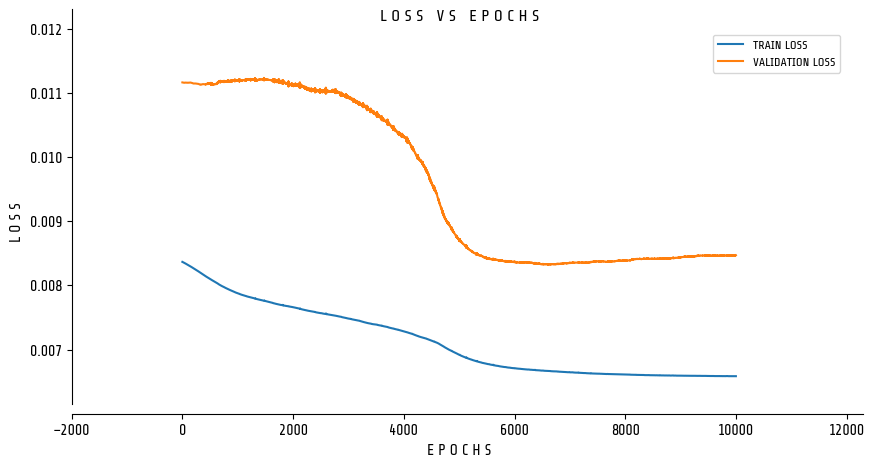

--------------------------------------------------------------------------------
✅ train_losses is correct!
✅ val_losses is correct!
✅ loss_trend is correct!
✅ overfit_check is correct!

🎉 Excellent! All parts are correct!


In [77]:
# Exercise 4: Creating a Training Loop 🎯
# In this exercise, you will:
# 1. Create a training loop for your neural network
# 2. Implement forward and backward passes
# 3. Monitor training and validation loss

def train_model(model,
                train_features,
                train_targets,
                val_features,
                val_targets,
                epochs=100):
    """
    Train a neural network model

    Args:
        model: PyTorch model to train
        train_features: Training features
        train_targets: Training targets
        val_features: Validation features
        val_targets: Validation targets
        epochs: Number of training epochs

    Returns:
        train_losses: List of training losses
        val_losses: List of validation losses
    """
    # Initialize lists to store losses
    train_losses = []
    val_losses = []

    # Put model in training mode
    model.train()

    # Training loop
    for epoch in tqdm(range(epochs), desc="Training"):
        # 1. Zero gradients
        model.optimizer.zero_grad()

        # 2. Forward pass
        predictions = model(train_features)

        # 3. Compute loss
        loss = model.loss_function(predictions, train_targets)

        # 4. Backward pass
        loss.backward()

        # 5. Update weights
        model.optimizer.step()

        # 6. Store training loss
        train_losses.append(loss.item())

        # 7. Compute validation loss
        model.eval() # Set model to evaluation mode
        with torch.no_grad(): # No need to track gradients for validation
            val_predictions = model(val_features)
            val_loss = model.loss_function(val_predictions, val_targets).item()
            val_losses.append(val_loss)

        # Set model back to training mode
        model.train()

    return train_losses, val_losses

# Run training for 100 epochs
train_losses, val_losses = train_model(
    model=model,
    train_features=X_train_scaled,
    train_targets=y_train_scaled,
    val_features=X_val_scaled,
    val_targets=y_val_scaled,
    epochs=10000
)

# Plot training and validation loss
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
utils.plotting.make_fig_pretty(ax, title='Loss vs Epochs', xlabel='Epochs', ylabel='Loss',ctab=True)
plt.show()

# ✅ Check your answer
answer = {
    'train_losses': train_losses[-1],
    'val_losses': val_losses[-1],
    'loss_trend': train_losses[0] > train_losses[-1],
    'overfit_check': val_losses[-1] <= val_losses[0] * 1.5  # Should not have increased much
}
checker.check_exercise(4, answer)

### Overfitting, Underfitting, and Early Stopping
***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/write.svg" width="20"/> **Definition**: Overfitting occurs when a model learns the training data too well, including noise and outliers, leading to poor generalisation on unseen data. Underfitting occurs when a model is too simple to capture the underlying patterns in the data.

As we can see in the following figure, the training loss decreases over time, while the validation loss follows a similar trend. However, the validation loss starts to slowly deviate from the training loss after a certain number of epochs. This indicates that the model is starting to overfit the training data. The point at which the validation loss starts to increase is known as the "early stopping" point. This is the point at which we should stop training the model to prevent overfitting.

<div align="center">
  <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/over_under_fit.png" width="70%">
</div>

## Step 10: Evaluate Model
***
The next step is to evaluate the model using the validation and test data. The model is evaluated on the validation set during training to monitor its performance and prevent overfitting.

Since we are training a model with MSE loss, we can also plot the predicted output against the actual output to see how well the model is performing. The predicted output should be close to the actual output, and the points should be clustered around the diagonal line. If the points are scattered far from the diagonal line, it indicates that the model is not performing well.

We can also compute the R-squared value to quantify the performance of the model. The R-squared value is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared value ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance in the data, and 1 indicates that the model explains all of the variance in the data.

For this step we are going to use the test set to evaluate the model.

***
> <img src="https://github.com/CLDiego/uom_fse_dl_workshop/raw/main/figs/icons/code.svg" width="20"/> **Snippet 3**: Evaluate Model

```python
# Set model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Forward pass through the model
    predictions = model(inputs)

    # Compute loss
    loss = criterion(predictions, targets)
```

Test Loss: 0.0079
R-squared Score: 0.8744
--------------------------------------------------------------------------------
✅ test_loss is correct!
✅ r2_score is correct!
✅ predictions_shape is correct!
✅ values_match is correct!

🎉 Excellent! All parts are correct!


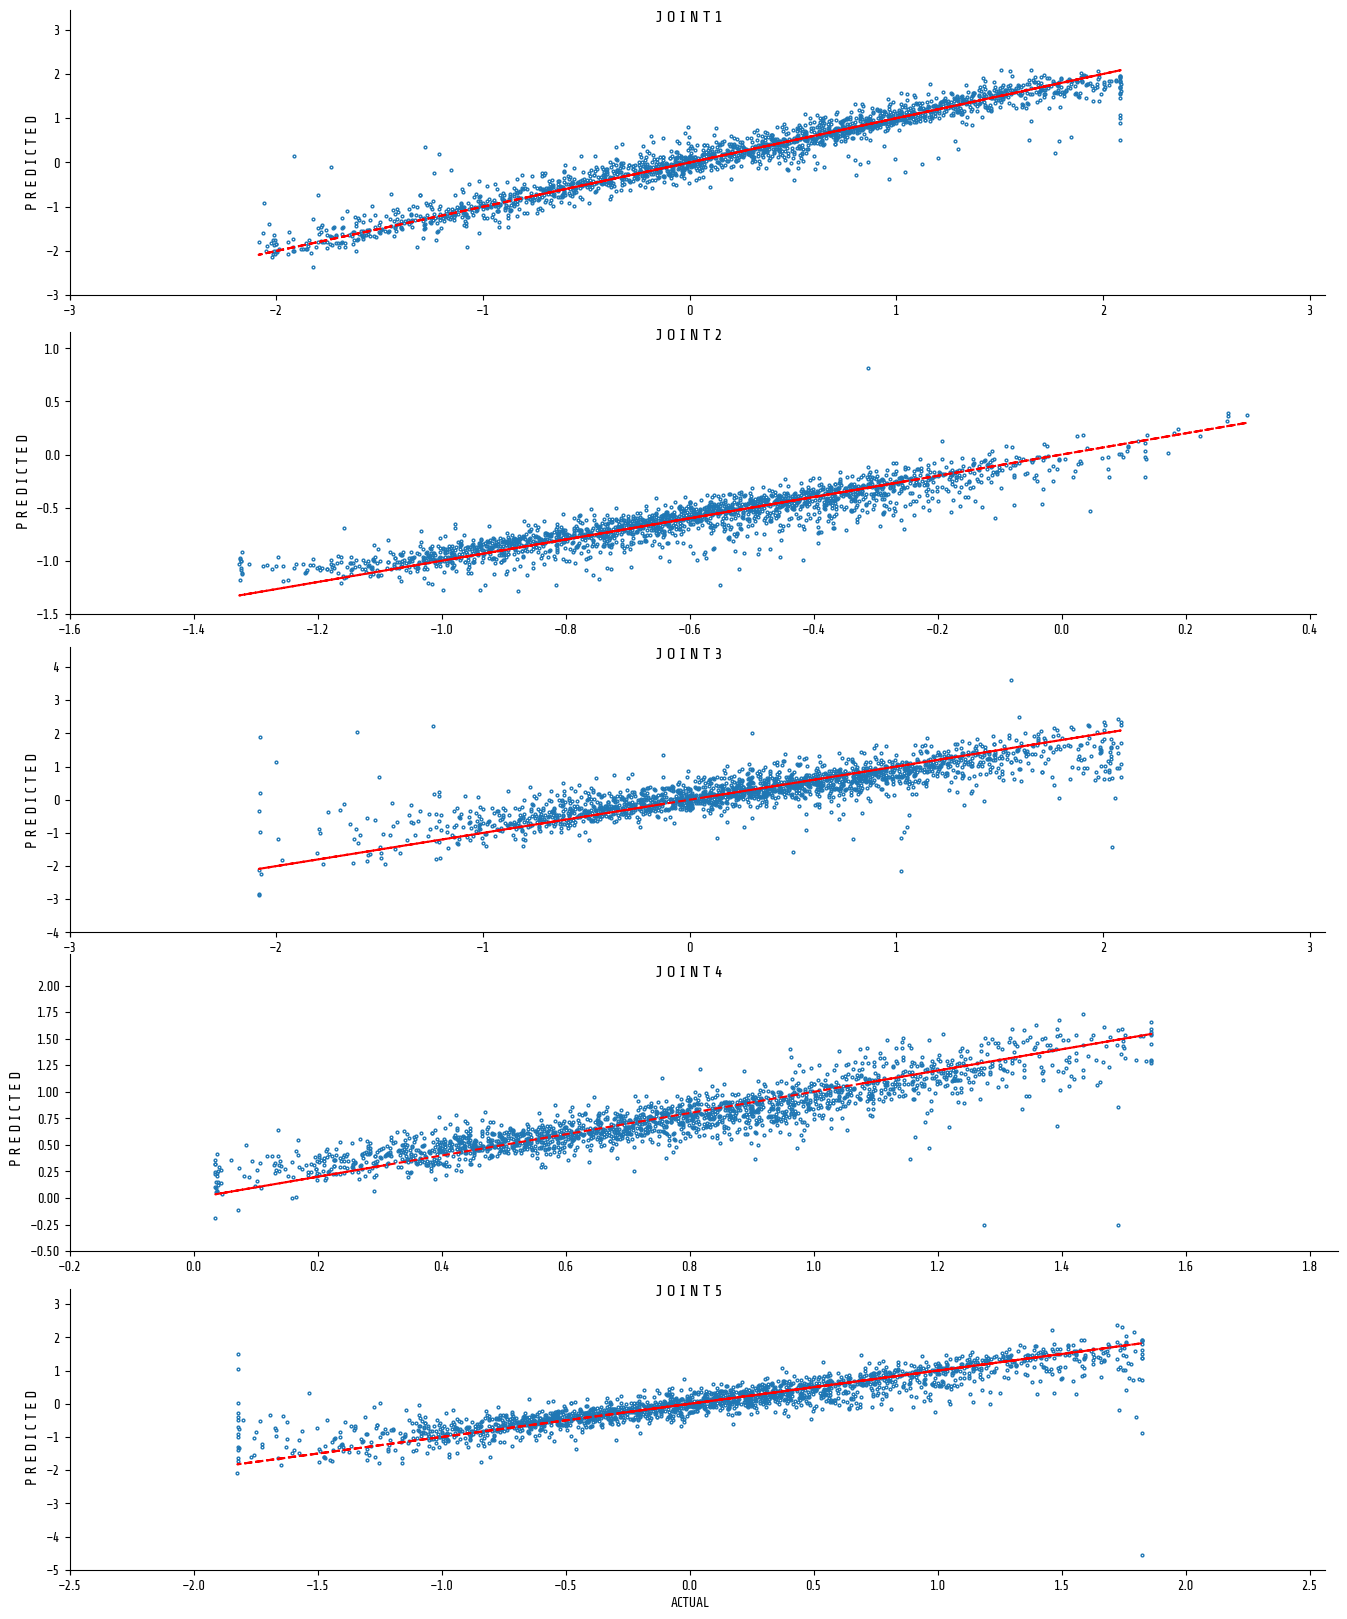

In [78]:
# Exercise 5: Model Evaluation 🎯
# In this exercise, you will:
# 1. Evaluate your trained model on the test set
# 2. Calculate R-squared score to measure model performance
# 3. Visualize actual vs. predicted values for one joint

# Put the model in evaluation mode
model.eval()

# Predict on the test set without computing gradients
with torch.no_grad():
    test_predictions = model(X_test_scaled)

    # Calculate the test loss
    test_loss = model.loss_function(test_predictions, y_test_scaled)

    # Convert predictions and targets back to original scale
    test_predictions_original = torch.tensor(y_scaler.inverse_transform(test_predictions))
    test_targets_original = torch.tensor(y_scaler.inverse_transform(y_test_scaled))

# Calculate the R-squared score
r2_score = utils.ml.r2_score(test_targets_original, test_predictions_original)

# Print evaluation metrics
print(f"Test Loss: {test_loss.item():.4f}")
print(f"R-squared Score: {r2_score:.4f}")

# Visualize actual vs. predicted values for the shoulder pitch joint (first joint)
fig, axes = plt.subplots(figsize=(16, 20), nrows=5)

for ix, joint in enumerate(y_test.columns):
    axes[ix].plot(test_targets_original[:, ix], test_predictions_original[:, ix], 'o', fillstyle='none', markersize=2)
    axes[ix].plot(test_targets_original[:, ix], test_targets_original[:, ix], 'r--')

    utils.plotting.make_fig_pretty(axes[ix], title=f"{joint}", ylabel='Predicted',
                                   xtick_fsize=10, ytick_fsize=10,
                                   title_fsize=12, xlabel_fsize=10)

    if ix == 4:
        axes[ix].set_xlabel('ACTUAL')



# ✅ Check your answer
answer = {
    'test_loss': test_loss.item(),
    'r2_score': r2_score,
    'predictions_shape': test_predictions_original.shape,
    'values_match': test_predictions_original.shape == test_targets_original.shape
}
checker.check_exercise(5, answer)